# Preprocessing - PAN 2012 Test Dataset

In [ ]:
from google.colab import drive
from config import *
from utils import *

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter

import matplotlib.pyplot as plt
import pandas as pd
import sqlite3 as sqlite
import numpy as np
import re

%matplotlib inline

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Increases the size limit of DataFrame columns
pd.set_option('display.max_colwidth', 500)

**Connecting to SQLite**


In [ ]:
connection = sqlite.connect('database.db')

print("Connection established!");

Connection established!


**Import file with sexual predators labels from test dataset**

In [ ]:
SEXUAL_PREDATORS = getSexualPredatorsTestDataset(DRIVE_PATH)

print('Number of sexual predators:', len(SEXUAL_PREDATORS))

Number of sexual predators: 254


## Functions

In [ ]:
def getDatasetInformation(df):
  print('UPDATED DATASET INFORMATION')
  print('----------------------------------------------\n')

  print('Number of conversations: ', len(df['conversation_id'].value_counts()))
  print('Number of messages: ', len(df['message']))
  print('Number of authors: ', len(df['author'].value_counts()))
  print('-')

  # Returns only messages from authors who are sexual predators
  query = '''SELECT * FROM conversations WHERE author in (%s)''' % ','.join('?'*len(SEXUAL_PREDATORS))
  aux = pd.read_sql(query, connection, params=SEXUAL_PREDATORS)

  print('Number of predatory conversations: ', len(aux['conversation_id'].unique()))
  print('Number of messages sent by sexual predators: ', len(aux['message']))
  print('Number of sexual predators: ', len(aux['author'].unique()))

In [ ]:
def getConversationsWithMoreWords(df):
  aux = df.copy()
  aux['words'] = df['message'].str.count(' ') + 1

  return aux[['conversation_id', 'words', 'message']].sort_values(by=['words'], ascending = False).head(10)

## Import test dataset

In [ ]:
dfBase = pd.read_csv(DRIVE_PATH + 'databases/test.csv', sep=';')

In [ ]:
dfBase

,conversation_id,line,author,time,message
0,affc2df0951b733d14ba92d19d9b7695,1,0a39f78bcb297ab0ebe8a29c28bfed89,15:24,bugmail: [Bug 6978] New: Mark eof-terminated script elements as malformed &lt;http://lists.w3.org/Archives/Public/public-html-bugzilla/2009May/0049.html&gt;
1,affc2df0951b733d14ba92d19d9b7695,2,60659cfda992013e610f285c46692d28,15:32,"Henri, can I ask you a Firefox build question (Windows)?"
2,affc2df0951b733d14ba92d19d9b7695,3,b8810fee2f4a71f849f3f7409546d1d9,15:34,"60659cfda992013e610f285c46692d28: sure, but I probably don't know the answer"
3,affc2df0951b733d14ba92d19d9b7695,4,60659cfda992013e610f285c46692d28,15:35,"It appears the build runs through, it creates a firefox.exe in dist/bin"
4,affc2df0951b733d14ba92d19d9b7695,5,60659cfda992013e610f285c46692d28,15:35,"when I start it, I get my standard install of FF (3.0.10) instead..."
...,...,...,...,...,...
2058776,8deed7c66340728e6863f3d931d4cca7,53,105ca6d0fd6c2c3e136980d3548f16ab,02:32,"Come the revolution, I'll worry about it"
2058777,8deed7c66340728e6863f3d931d4cca7,54,48a4fba2c4916bbc8aae694a3877dca3,02:33,no pasaran!
2058778,8deed7c66340728e6863f3d931d4cca7,55,48a4fba2c4916bbc8aae694a3877dca3,02:33,:)
2058779,8deed7c66340728e6863f3d931d4cca7,56,e1e3d026bb7ee9ee264316da10378aeb,02:35,25mhz is slow :(


In [ ]:
# Info

dfBase.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2058781 entries, 0 to 2058780
Data columns (total 5 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   conversation_id  2058781 non-null  object
 1   line             2058781 non-null  int64 
 2   author           2058781 non-null  object
 3   time             2058781 non-null  object
 4   message          2052320 non-null  object
dtypes: int64(1), object(4)
memory usage: 78.5+ MB


In [ ]:
# Number of null values by column

dfBase.isnull().sum()

conversation_id       0
line                  0
author                0
time                  0
message            6461
dtype: int64

## Preprocessing

**Creating a copy of the message column for message comparison**

In [ ]:
dfBase['original_message'] = dfBase['message']

In [ ]:
dfBase.head()

,conversation_id,line,author,time,message,original_message
0,affc2df0951b733d14ba92d19d9b7695,1,0a39f78bcb297ab0ebe8a29c28bfed89,15:24,bugmail: [Bug 6978] New: Mark eof-terminated script elements as malformed &lt;http://lists.w3.org/Archives/Public/public-html-bugzilla/2009May/0049.html&gt;,bugmail: [Bug 6978] New: Mark eof-terminated script elements as malformed &lt;http://lists.w3.org/Archives/Public/public-html-bugzilla/2009May/0049.html&gt;
1,affc2df0951b733d14ba92d19d9b7695,2,60659cfda992013e610f285c46692d28,15:32,"Henri, can I ask you a Firefox build question (Windows)?","Henri, can I ask you a Firefox build question (Windows)?"
2,affc2df0951b733d14ba92d19d9b7695,3,b8810fee2f4a71f849f3f7409546d1d9,15:34,"60659cfda992013e610f285c46692d28: sure, but I probably don't know the answer","60659cfda992013e610f285c46692d28: sure, but I probably don't know the answer"
3,affc2df0951b733d14ba92d19d9b7695,4,60659cfda992013e610f285c46692d28,15:35,"It appears the build runs through, it creates a firefox.exe in dist/bin","It appears the build runs through, it creates a firefox.exe in dist/bin"
4,affc2df0951b733d14ba92d19d9b7695,5,60659cfda992013e610f285c46692d28,15:35,"when I start it, I get my standard install of FF (3.0.10) instead...","when I start it, I get my standard install of FF (3.0.10) instead..."


In [ ]:
# Saving dataframe in SQLite database
dfBase.to_sql('conversations', connection, if_exists='replace', index=False)

### Information before preprocessing

In [ ]:
getDatasetInformation(dfBase)

UPDATED DATASET INFORMATION
----------------------------------------------

Number of conversations:  155128
Number of messages:  2058781
Number of authors:  218702
-
Number of predatory conversations:  3737
Number of messages sent by sexual predators:  65239
Number of sexual predators:  254


### Number of words per message

In [ ]:
getConversationsWithMoreWords(dfBase)

,conversation_id,words,message
1154703,1f2e4d84235e1c25a021fc3051e7012b,142234.0,hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi h...
742933,4a50afdaf8a6369a2cdeb9fae95c47e8,79381.0,SEXY GUY GREEK LOVER 29CM MSN?SEXY GUY GREEK LOVER 29CM MSN?SEXY GUY GREEK LOVER 29CM MSN?SEXY GUY GREEK LOVER 29CM MSN?SEXY GUY GREEK LOVER 29CM MSN?SEXY GUY GREEK LOVER 29CM MSN?SEXY GUY GREEK LOVER 29CM MSN?SEXY GUY GREEK LOVER 29CM MSN?SEXY GUY GREEK LOVER 29CM MSN?SEXY GUY GREEK LOVER 29CM MSN?SEXY GUY GREEK LOVER 29CM MSN?SEXY GUY GREEK LOVER 29CM MSN?SEXY GUY GREEK LOVER 29CM MSN?SEXY GUY GREEK LOVER 29CM MSN?SEXY GUY GREEK LOVER 29CM MSN?SEXY GUY GREEK LOVER 29CM MSN?SEXY GUY GREEK L...
1440366,797f1fcca484e6ca59e2e60a19c0b9d9,74291.0,shpx lbh unun qhzo ovgpu pubxr ba zl qvpx zbgure shpxreshpx lbh unun qhzo ovgpu pubxr ba zl qvpx zbgure shpxreshpx lbh unun qhzo ovgpu pubxr ba zl qvpx zbgure shpxreshpx lbh unun qhzo ovgpu pubxr ba zl qvpx zbgure shpxreshpx lbh unun qhzo ovgpu pubxr ba zl qvpx zbgure shpxreshpx lbh unun qhzo ovshpx lbh unun qhzo ovgpu pubxr ba zl qvpx zbgure shpxreshpx lbh unun qhzo ovgpu pubxr ba zl qvpx zbgure shpxreshpx lbh unun qhzo ovgpu pubxr ba zl qvpx zbgure shpxreshpx lbh unun qhzo ovgpu pubxr ba z...
145037,f65b3cd03061a6c18fcd76da5c25d028,58202.0,herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp d...
243278,10f6fef4fcb10e69ce9fff48243cd138,43429.0,"………………….._,,-~’’’¯¯¯’’~-,,\n………………..,-‘’ ; ; ;_,,---,,_ ; ;’’-,…………………………….._,,,---,,_\n……………….,’ ; ; ;,-‘ , , , , , ‘-, ; ;’-,,,,---~~’’’’’’~--,,,_…..,,-~’’ ; ; ; ;__;’-,\n……………….| ; ; ;,’ , , , _,,-~’’ ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ¯’’~’-,,_ ,,-~’’ , , ‘, ;’,\n……………….’, ; ; ‘-, ,-~’’ ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ;’’-, , , , , ,’ ; |\n…………………’, ; ;,’’ ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ;’-, , ,-‘ ;,-‘\n………………….,’-‘ ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ..."
1603958,fb3d4eed418b63ab85e394db88a1ad49,39101.0,OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAM...
1603956,fb3d4eed418b63ab85e394db88a1ad49,20401.0,OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAM...
79185,1b335ae481e906770f3e5604ed67cc06,18486.0,* Skip past navigation\n * On a mobile phone? Check out m.twitter.com!\n * Skip

### 1- Delete null messages

In [ ]:
dfBase.dropna(subset=['message'], inplace=True)
dfBase.reset_index(drop=True, inplace=True)

# Saving dataframe in SQLite database
dfBase.to_sql('conversations', connection, if_exists='replace', index=False)

In [ ]:
getDatasetInformation(dfBase)

UPDATED DATASET INFORMATION
----------------------------------------------

Number of conversations:  155101
Number of messages:  2052320
Number of authors:  218681
-
Number of predatory conversations:  3723
Number of messages sent by sexual predators:  64982
Number of sexual predators:  254


### 2- Convert messages to lowercase

In [ ]:
dfBase['message'] = dfBase['message'].str.lower()

In [ ]:
dfBase.head()

,conversation_id,line,author,time,message,original_message
0,affc2df0951b733d14ba92d19d9b7695,1,0a39f78bcb297ab0ebe8a29c28bfed89,15:24,bugmail: [bug 6978] new: mark eof-terminated script elements as malformed &lt;http://lists.w3.org/archives/public/public-html-bugzilla/2009may/0049.html&gt;,bugmail: [Bug 6978] New: Mark eof-terminated script elements as malformed &lt;http://lists.w3.org/Archives/Public/public-html-bugzilla/2009May/0049.html&gt;
1,affc2df0951b733d14ba92d19d9b7695,2,60659cfda992013e610f285c46692d28,15:32,"henri, can i ask you a firefox build question (windows)?","Henri, can I ask you a Firefox build question (Windows)?"
2,affc2df0951b733d14ba92d19d9b7695,3,b8810fee2f4a71f849f3f7409546d1d9,15:34,"60659cfda992013e610f285c46692d28: sure, but i probably don't know the answer","60659cfda992013e610f285c46692d28: sure, but I probably don't know the answer"
3,affc2df0951b733d14ba92d19d9b7695,4,60659cfda992013e610f285c46692d28,15:35,"it appears the build runs through, it creates a firefox.exe in dist/bin","It appears the build runs through, it creates a firefox.exe in dist/bin"
4,affc2df0951b733d14ba92d19d9b7695,5,60659cfda992013e610f285c46692d28,15:35,"when i start it, i get my standard install of ff (3.0.10) instead...","when I start it, I get my standard install of FF (3.0.10) instead..."


In [ ]:
# Saving dataframe in SQLite database
dfBase.to_sql('conversations', connection, if_exists='replace', index=False)

### 3- Remove HTML character entities and \\n, \\r and \\t

#### Remove HTML character entities

In [ ]:
dfBase['message'] = dfBase['message'].str.replace('&lt;', '') # <
dfBase['message'] = dfBase['message'].str.replace('&gt;', '') # >
dfBase['message'] = dfBase['message'].str.replace('&amp;', '') # &
dfBase['message'] = dfBase['message'].str.replace('&quot;', '') # " (double quotes)
dfBase['message'] = dfBase['message'].str.replace('&apos;', '') # ' (single quotes)

#### Remove \\n, \\r e \\t

In [ ]:
i=0
j=0
for message in dfBase['message']:
  m = re.search(r'\\n', message)
  n = re.search(r'\n', message)
  if m:
    i=i+1

  if n:
    j=j+1

print('Number of \\\\n:', i)
print('Number of \\n:', j)

Number of \\n: 512
Number of \n: 4828


**Replaces \n, \r and \t with empty space because some words have no space between them and punctuation**

In [ ]:
dfBase['message'] = dfBase['message'].str.replace(r'\\n|\\r|\\t', ' ', regex=True)
dfBase['message'] = dfBase['message'].str.replace(r'\n|\r|\t', ' ', regex=True)

In [ ]:
# Example

dfBase[dfBase['conversation_id'] == '837c8ceacae44ee18bd45c96b17599da'][['message', 'original_message']][99:100]

,message,original_message
1983633,you: justin beiber likes men you: justin beiber likes men you: justin beiber likes men you: justin beiber likes men you: justin beiber likes men you: justin beiber likes men you: justin beiber likes men you: justin beiber likes men you: justin beiber likes men you: justin beiber likes men you: justin beiber likes men you: justin beiber likes men you: justin beiber likes men you: justin beiber likes men you: justin beiber likes men you: justin beiber likes men you: justin beiber likes men you...,You: justin beiber likes men\nYou: justin beiber likes men\nYou: justin beiber likes men\nYou: justin beiber likes men\nYou: justin beiber likes men\nYou: justin beiber likes men\nYou: justin beiber likes men\nYou: justin beiber likes men\nYou: justin beiber likes men\nYou: justin beiber likes men\nYou: justin beiber likes men\nYou: justin beiber likes men\nYou: justin beiber likes men\nYou: justin beiber likes men\nYou: justin beiber likes men\nYou: justin beiber likes men\nYou: justin beib...


In [ ]:
# Saving dataframe in SQLite database
dfBase.to_sql('conversations', connection, if_exists='replace', index=False)

### 4- Remove URLs

In [ ]:
i=0
for message in dfBase['message']:
  m = re.search('https?:\/\/\S+|www\.\S+', message)
  if m:
    i=i+1
    #print(m.group(0))

print('Number of URLs:', i)

Number of URLs: 62691


In [ ]:
dfBase['message'] = dfBase['message'].str.replace('https?:\/\/\S+|www\.\S+', '', regex=True)

In [ ]:
# Saving dataframe in SQLite database
dfBase.to_sql('conversations', connection, if_exists='replace', index=False)

### 5- Remove punctuation, unknown and accented letters

**Replaces punctuation with space because some words have no space between them and punctuation**

**Only single quotes don't need space**

In [ ]:
dfBase['message'] = dfBase['message'].str.replace('\'', '')
dfBase['message'] = dfBase['message'].str.replace('[^a-z0-9\s]', ' ', regex=True)

In [ ]:
# Example

dfBase[['message', 'original_message']][:5]

,message,original_message
0,bugmail bug 6978 new mark eof terminated script elements as malformed,bugmail: [Bug 6978] New: Mark eof-terminated script elements as malformed &lt;http://lists.w3.org/Archives/Public/public-html-bugzilla/2009May/0049.html&gt;
1,henri can i ask you a firefox build question windows,"Henri, can I ask you a Firefox build question (Windows)?"
2,60659cfda992013e610f285c46692d28 sure but i probably dont know the answer,"60659cfda992013e610f285c46692d28: sure, but I probably don't know the answer"
3,it appears the build runs through it creates a firefox exe in dist bin,"It appears the build runs through, it creates a firefox.exe in dist/bin"
4,when i start it i get my standard install of ff 3 0 10 instead,"when I start it, I get my standard install of FF (3.0.10) instead..."


In [ ]:
# Example

dfBase[dfBase['conversation_id'] == '10f6fef4fcb10e69ce9fff48243cd138'][['message', 'original_message']]

,message,original_message
242345,hi,hi
242346,i challenge you to a pokemon battle,I CHALLENGE YOU TO A POKEMON BATTLE!
242347,i accept,I ACCEPT
242348,...,"………………….._,,-~’’’¯¯¯’’~-,,\n………………..,-‘’ ; ; ;_,,---,,_ ; ;’’-,…………………………….._,,,---,,_\n……………….,’ ; ; ;,-‘ , , , , , ‘-, ; ;’-,,,,---~~’’’’’’~--,,,_…..,,-~’’ ; ; ; ;__;’-,\n……………….| ; ; ;,’ , , , _,,-~’’ ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ¯’’~’-,,_ ,,-~’’ , , ‘, ;’,\n……………….’, ; ; ‘-, ,-~’’ ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ;’’-, , , , , ,’ ; |\n…………………’, ; ;,’’ ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ;’-, , ,-‘ ;,-‘\n………………….,’-‘ ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ..."
242349,go charizard,GO CHARIZARD
242350,lmao,LMAO
242351,go pedobear,GO PEDOBEAR!!
242352,...,"………………….._,,-~’’’¯¯¯’’~-,,\n………………..,-‘’ ; ; ;_,,---,,_ ; ;’’-,…………………………….._,,,---,,_\n……………….,’ ; ; ;,-‘ , , , , , ‘-, ; ;’-,,,,---~~’’’’’’~--,,,_…..,,-~’’ ; ; ; ;__;’-,\n……………….| ; ; ;,’ , , , _,,-~’’ ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ¯’’~’-,,_ ,,-~’’ , , ‘, ;’,\n……………….’, ; ; ‘-, ,-~’’ ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ;’’-, , , , , ,’ ; |\n…………………’, ; ;,’’ ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ;’-, , ,-‘ ;,-‘\n………………….,’-‘ ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ; ..."
242353,pedo bear ohhhhh no,pedo bear ohhhhh no
242354,i lost,i lost :(


In [ ]:
# Saving dataframe in SQLite database
dfBase.to_sql('conversations', connection, if_exists='replace', index=False)

### 6- Remove empty spaces in sequence

In [ ]:
i=0
for message in dfBase['message']:
  m = re.search('\s{2,}', message)
  if m:
    i=i+1

print('Number of messages with more than 2 spaces in sequence:', i)

Number of messages with more than 2 spaces in sequence: 720968


In [ ]:
# Remove spaces in sequence
dfBase['message'] = dfBase['message'].str.replace('\s{2,}', ' ', regex=True)

# Remove spaces at the beginning and end
dfBase['message'] = dfBase['message'].apply(lambda m: m.strip())

In [ ]:
# Saving dataframe in SQLite database
dfBase.to_sql('conversations', connection, if_exists='replace', index=False)

### 7- Delete empty messages

In [ ]:
print('Number of empty messages:', len(dfBase[dfBase['message'] == '']))

Number of empty messages: 61764


In [ ]:
# 50 first examples

dfBase[dfBase['message'] == ''][['conversation_id', 'message', 'original_message']].head(50)

,conversation_id,message,original_message
26,affc2df0951b733d14ba92d19d9b7695,,http://www.w3.org/html/wg/tracker/actions/123
88,de15188e9fd515ed817a0b34546be902,,:-*
91,de15188e9fd515ed817a0b34546be902,,:-*
99,17784c5a093477c1706b1a68cea7c802,,?
102,17784c5a093477c1706b1a68cea7c802,,?
162,17784c5a093477c1706b1a68cea7c802,,^^
174,80e3c3978ea07f46819f1f945cb04949,,=)
185,15a38614944f5aa8bbb59d4153ecc12a,,...
214,15a38614944f5aa8bbb59d4153ecc12a,,..........
227,15a38614944f5aa8bbb59d4153ecc12a,,...


**Replace empty spaces with null**

In [ ]:
dfBase['message'].replace('', np.nan, inplace=True)

In [ ]:
# Number of null values by column

dfBase.isnull().sum()

conversation_id         0
line                    0
author                  0
time                    0
message             61764
original_message        0
dtype: int64

In [ ]:
# Example of messages sent by sexual predators that will be deleted

dfBase[(dfBase['message'].isnull()) & (dfBase['author'] == 'fadde1cb70225e72e78a5836425471f5')]

,conversation_id,line,author,time,message,original_message
62229,dcf0e18f665f2dc62d3d332c63c144d7,5,fadde1cb70225e72e78a5836425471f5,18:52,NaN,:((
1286667,bd7b595c17dbff9eb3a80d20e55b89c3,121,fadde1cb70225e72e78a5836425471f5,17:48,NaN,:-*
1409601,9c4cdc4ea313a5743f01c4cd7dd11082,22,fadde1cb70225e72e78a5836425471f5,00:12,NaN,??


In [ ]:
# Example of messages sent by sexual predators that will be deleted

dfBase[(dfBase['message'].isnull()) & (dfBase['author'] == 'd2cd98d625d8f8d91f78497efd39a74f')]

,conversation_id,line,author,time,message,original_message
109838,177edab4049549c79349de383616e5c3,22,d2cd98d625d8f8d91f78497efd39a74f,20:23,NaN,;)
109861,177edab4049549c79349de383616e5c3,45,d2cd98d625d8f8d91f78497efd39a74f,21:25,NaN,:*
109890,177edab4049549c79349de383616e5c3,74,d2cd98d625d8f8d91f78497efd39a74f,22:12,NaN,:(
109915,177edab4049549c79349de383616e5c3,99,d2cd98d625d8f8d91f78497efd39a74f,22:48,NaN,;;)
109935,177edab4049549c79349de383616e5c3,119,d2cd98d625d8f8d91f78497efd39a74f,23:34,NaN,;;)
244343,9f3253c7ecf02482c444256c336d8a2b,1,d2cd98d625d8f8d91f78497efd39a74f,18:53,NaN,;;)
273214,fcf0cdb533c2dc380230471ea751c8c1,23,d2cd98d625d8f8d91f78497efd39a74f,18:50,NaN,:*
273256,fcf0cdb533c2dc380230471ea751c8c1,65,d2cd98d625d8f8d91f78497efd39a74f,19:29,NaN,;;)
273258,fcf0cdb533c2dc380230471ea751c8c1,67,d2cd98d625d8f8d91f78497efd39a74f,19:34,NaN,:-/:(
286753,131b7281de85c0722e6029e6e27c9069,2,d2cd98d625d8f8d91f78497efd39a74f,19:53,NaN,;;)


**Delete messages that are null**

In [ ]:
dfBase.dropna(subset=['message'], inplace=True)
dfBase.reset_index(drop=True, inplace=True)

# Saving dataframe in SQLite database
dfBase.to_sql('conversations', connection, if_exists='replace', index=False)

In [ ]:
getDatasetInformation(dfBase)

UPDATED DATASET INFORMATION
----------------------------------------------

Number of conversations:  154732
Number of messages:  1990556
Number of authors:  217851
-
Number of predatory conversations:  3690
Number of messages sent by sexual predators:  63327
Number of sexual predators:  254


### 8- Remove repeated letters in a word

In [ ]:
"""
Adapted from https://github.com/biemt-pesc-coppe-ufrj/exemplosXexeo/blob/8438dcfd5ee5594123be1bcaa52e30a18c53e425/Norvig%20Simples/bimt_spell.py

"""

def removeRepeatedLetters(word):
  "Remove repeated letters in a word."

  return re.sub('([a-zA-Z])(?=(\\1){2})', '', word)

In [ ]:
dfBase['message'] = dfBase['message'].apply(lambda m: removeRepeatedLetters(m))

### 9- Remove repeated words in sequence

In [ ]:
i=0
for message in dfBase['message']:
  m = re.search(r'\b(.+)\s+\1\b', message)
  if m and m.group(0).strip():
    i=i+1
    #print(m.group(0))

print('Number of messages with some repeated word::', i)

Number of messages with some repeated word:: 24733


In [ ]:
# Remove repeated words
dfBase['message'] = dfBase['message'].apply(lambda m: removeRepeatedWordsInSequence(m))

# Saving dataframe in SQLite database
dfBase.to_sql('conversations', connection, if_exists='replace', index=False)

In [ ]:
# Example

dfBase[dfBase['conversation_id'] == '1f2e4d84235e1c25a021fc3051e7012b'][['message', 'original_message']]

,message,original_message
1116868,hi,hi
1116869,hi,hi
1116870,hi,hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi h...
1116871,how are you,how are you?
1116872,im actually kind of scared,i&apos;m actually kind of scared


In [ ]:
# Example

dfBase[dfBase['conversation_id'] == 'fb3d4eed418b63ab85e394db88a1ad49'][['message', 'original_message']][:10]

,message,original_message
1551385,obama,OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAM...
1551386,is black,is black
1551387,whatd you call me,whatd you call me?
1551388,obama,OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAM...
1551389,obama,OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAM...
1551390,obama,OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAM...
1551391,obama,OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAM...
1551392,obama,OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAM...
1551393,obama,OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAM...
1551394,obama,OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBA

**Comparing amount of words before and after removing repeated words**

In [ ]:
df = dfBase.copy()
df['words_before'] = df['original_message'].str.count(' ') + 1
df['words_after'] = df['message'].str.count(' ') + 1

df[['words_before', 'original_message', 'words_after', 'message']].sort_values(by=['words_before'], ascending = False).head(10)

,words_before,original_message,words_after,message
1116870,142234,hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi hi h...,1,hi
718941,79381,SEXY GUY GREEK LOVER 29CM MSN?SEXY GUY GREEK LOVER 29CM MSN?SEXY GUY GREEK LOVER 29CM MSN?SEXY GUY GREEK LOVER 29CM MSN?SEXY GUY GREEK LOVER 29CM MSN?SEXY GUY GREEK LOVER 29CM MSN?SEXY GUY GREEK LOVER 29CM MSN?SEXY GUY GREEK LOVER 29CM MSN?SEXY GUY GREEK LOVER 29CM MSN?SEXY GUY GREEK LOVER 29CM MSN?SEXY GUY GREEK LOVER 29CM MSN?SEXY GUY GREEK LOVER 29CM MSN?SEXY GUY GREEK LOVER 29CM MSN?SEXY GUY GREEK LOVER 29CM MSN?SEXY GUY GREEK LOVER 29CM MSN?SEXY GUY GREEK LOVER 29CM MSN?SEXY GUY GREEK L...,6,sexy guy greek lover 29cm msn
1393155,74291,shpx lbh unun qhzo ovgpu pubxr ba zl qvpx zbgure shpxreshpx lbh unun qhzo ovgpu pubxr ba zl qvpx zbgure shpxreshpx lbh unun qhzo ovgpu pubxr ba zl qvpx zbgure shpxreshpx lbh unun qhzo ovgpu pubxr ba zl qvpx zbgure shpxreshpx lbh unun qhzo ovgpu pubxr ba zl qvpx zbgure shpxreshpx lbh unun qhzo ovshpx lbh unun qhzo ovgpu pubxr ba zl qvpx zbgure shpxreshpx lbh unun qhzo ovgpu pubxr ba zl qvpx zbgure shpxreshpx lbh unun qhzo ovgpu pubxr ba zl qvpx zbgure shpxreshpx lbh unun qhzo ovgpu pubxr ba z...,51,shpx lbh unun qhzo ovgpu pubxr ba zl qvpx zbgure shpxreshpx lbh unun qhzo ovshpx lbh unun qhzo ovgpu pubxr ba zl qvpx zbgure shpxreshpx lbh unun qhzo ovgpu pubxr ba zl qvpx zbgure shpxregpu pubxr ba zl qvpx zbgure shpxreshpx lbh unun qhzo ovgpu pubxr ba zl qvpx zbgure shpxre
140082,58202,herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp derp herp d...,7,herp derp herp derpherp derp herp derp
1551414,39101,OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAM...,3,obama obamaobama obama
1551412,20401,OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAMA OBAM...,3,obama obamaobama obama
76518,18486,* Skip past navigation\n * On a mobile phone? Check out m.twitter.com!\n * Skip to navigation\n * Jump to the sidebar\n * Skip to sign in form\n\nLoader\nTwitter.com\n\n * Home\n * Profile\n * Find People\n * Settings\n * Help\n * Sign out\n\nWhat’s happening?\n140\nTweet\nLatest: I know the 61 people that aren&apos;t following me back thanks to http://who.unfollowed.me #notfollowingback about 3 hours agoLatest: I know the 61 people that aren&

### Information after preprocessing

In [ ]:
getDatasetInformation(dfBase)

UPDATED DATASET INFORMATION
----------------------------------------------

Number of conversations:  154732
Number of messages:  1990556
Number of authors:  217851
-
Number of predatory conversations:  3690
Number of messages sent by sexual predators:  63327
Number of sexual predators:  254


### Number of words per message

In [ ]:
getConversationsWithMoreWords(dfBase)

,conversation_id,words,message
76518,1b335ae481e906770f3e5604ed67cc06,8108,skip past navigation on a mobile phone check out m twitter com skip to navigation jump to the sidebar skip to sign in form loader twitter com home profile find people settings help sign out what s happening 140 tweet latest i know the 61 people that arent following me back thanks to notfollowingback about 3 hours agolatest i know the 61 people that arent following me back thanks to notfollowingback about 3 hours ago from who unfollowed me send a direct message 140 name results for view all n...
334720,e058a8861072cbc1d8d4bd199bd37ee4,5704,la constitution crit g n ralement avec une majuscule est un texte qui fixe lorganisation et le fonctionnement dun organisme g n ralement dun tat la constitution dun tat a valeur de loi est la fois lacte politique valeur juridique et la loi fondamentale qui unit et r git de mani re organis e et hi rarchis e l ensemble des rapports entre gouvernants et gouvern s au sein de cet tat en tant quunit despace g ographique et humain la constitution garantit les droits et les libert s de la communaut ...
334719,e058a8861072cbc1d8d4bd199bd37ee4,5704,la constitution crit g n ralement avec une majuscule est un texte qui fixe lorganisation et le fonctionnement dun organisme g n ralement dun tat la constitution dun tat a valeur de loi est la fois lacte politique valeur juridique et la loi fondamentale qui unit et r git de mani re organis e et hi rarchis e l ensemble des rapports entre gouvernants et gouvern s au sein de cet tat en tant quunit despace g ographique et humain la constitution garantit les droits et les libert s de la communaut ...
656366,0c0b2ee8b593ee347dd23bd3a577e31c,4724,youre now chatting with a random stranger say hi official messages from omegle will not be sent with the label stranger strangers claiming to represent omegle are lying stranger hey you howdy stranger you are you normal stranger yes you that sucks you damn stranger wait you oh well ill try it stranger f you u you lol nvm you nah im a guy you perv stranger r u gay you bye you r u dumb stranger yes you dumber than you sound i mean you like clinically retardeed you lol jk you love ya man you oh...
1922213,d4c8e535c325f4d9eb4a2c0a892ef653,3548,adobe flash do bi fl kurz flash ehemals macromedia flash ist eine propriet re integrierte entwicklungsumgebung von adobe systems zur erstellung multimedialer interaktiver inhalte der so genannten flash filme der benutzer produziert mit dieser software dateien im propriet ren swf format bekannt und umgangssprachlich gemeint ist flash als flash player eine softwarekomponente zum betrachten dieser swf dateien der flash player ist einer der am meisten verbreiteten browser plug ins neben der offe...
1530371,3046adfa39aebe622d9cc90a5bc4a172,2465,it was oct 7th anna remembered well as in all other days she got up took a shower washed her hair put some clothier ate something and went to school when the girl arrived home she opened her msn a new invitation accept she thought it was her intuition he was a boy named bruno they began talking and then discovered they liked the same bands food everything they had almost everything in common except one thing the city the boy lived in london the girl in bolton a small town in south of england...
942199,5634f15360c25c42d7020a1c375ea620,2439,the early years 1989 1992 while attending a charity gig at the jordanstown polytechnic in early 1989 andy cairns noticed fyfe ewing playing drums in a punk covers band the two spoke afterwards and agreed to meet for rehearsal in fyfes house in larne with andy playing a small practice amp and fyfe playing his kit with brushes in the summer they recorded a four track demo tape thirty seconds of silence with andy playing a bass guitar borrowed from fyfes classmate michael mckeegan deciding to p...
942202,5634f15360c25c42d7020a1c375ea620,2439,the early years 1989 1992 while attending a charity gig at the jordanstown polytechnic in early 1989 andy ca

### Number of authors per conversation

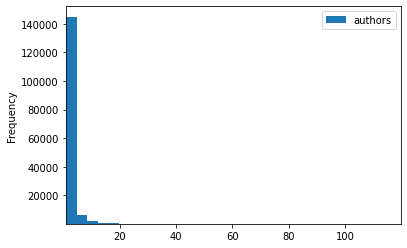

In [ ]:
# Number of authors per conversation

query = '''SELECT conversation_id, count(distinct(author)) as authors
           FROM conversations 
           GROUP BY conversation_id 
           ORDER BY authors desc;'''

df = pd.read_sql(query, connection)
df.plot.hist(bins=30, ylim=(1), xlim=(1))

### Number of messages per conversation

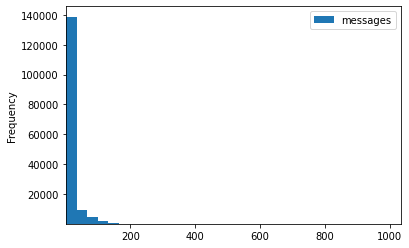

In [ ]:
# Number of messages per conversation

query = '''SELECT conversation_id, count(distinct(message)) as messages
           FROM conversations 
           GROUP BY conversation_id 
           ORDER BY messages desc;'''

df = pd.read_sql(query, connection)
df.plot.hist(bins=30, ylim=(1), xlim=(1))

### WordCloud

#### WordCloud of all messages

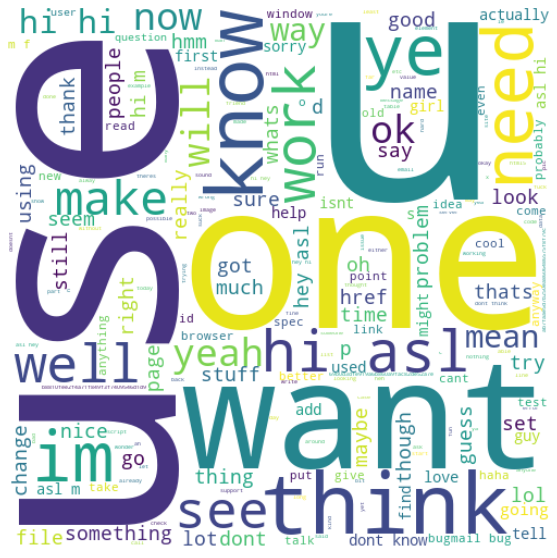

In [ ]:
text = " ".join(message for message in dfBase['message'])

wordcloud = WordCloud(width=500, height=500, background_color="white").generate(text)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Saving image
wordcloud.to_file("wordcloud.png")

#### WordCloud of sexual predators messages

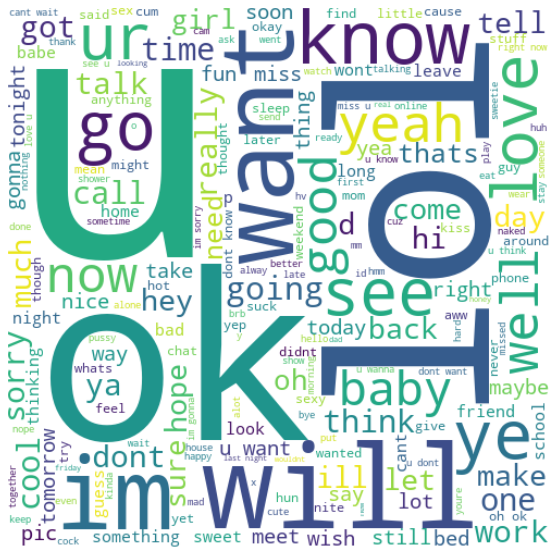

In [ ]:
# Returns only messages from authors who are sexual predators
query = '''SELECT * FROM conversations WHERE author in (%s)''' % ','.join('?'*len(SEXUAL_PREDATORS))
aux = pd.read_sql(query, connection, params=SEXUAL_PREDATORS)

text = " ".join(message for message in aux['message'])

wordcloud = WordCloud(width=500, height=500, background_color="white").generate(text)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Saving image
wordcloud.to_file("wordcloud_predators.png")

### Save preprocessed dataset

In [ ]:
# Dropping column "original_message"

dfBase.drop('original_message', inplace=True, axis=1)

#### Save predatory conversations dataset

In [ ]:
dfPredatoryConversations = dfBase.copy()

# Returns only messages from authors who are sexual predators
query = '''SELECT * FROM conversations WHERE author in (%s)''' % ','.join('?'*len(SEXUAL_PREDATORS))
aux = pd.read_sql(query, connection, params=SEXUAL_PREDATORS)

predatoryConversations = aux['conversation_id'].unique()

# Adding column "predatory_conversation" with value False initially
# When the conversation is a predatory conversation, the label will be changed to True

dfPredatoryConversations = dfPredatoryConversations.assign(predatory_conversation = False)

for predatoryConversation in predatoryConversations:
  dfPredatoryConversations.loc[(dfPredatoryConversations['conversation_id'] ==  predatoryConversation), ['predatory_conversation']] = True

In [ ]:
dfPredatoryConversations

,conversation_id,line,author,time,message,predatory_conversation
0,affc2df0951b733d14ba92d19d9b7695,1,0a39f78bcb297ab0ebe8a29c28bfed89,15:24,bugmail bug 6978 new mark eof terminated script elements as malformed,False
1,affc2df0951b733d14ba92d19d9b7695,2,60659cfda992013e610f285c46692d28,15:32,henri can i ask you a firefox build question windows,False
2,affc2df0951b733d14ba92d19d9b7695,3,b8810fee2f4a71f849f3f7409546d1d9,15:34,60659cfda992013e610f285c46692d28 sure but i probably dont know the answer,False
3,affc2df0951b733d14ba92d19d9b7695,4,60659cfda992013e610f285c46692d28,15:35,it appears the build runs through it creates a firefox exe in dist bin,False
4,affc2df0951b733d14ba92d19d9b7695,5,60659cfda992013e610f285c46692d28,15:35,when i start it i get my standard install of ff 3 0 10 instead,False
...,...,...,...,...,...,...
1990551,8deed7c66340728e6863f3d931d4cca7,52,48a4fba2c4916bbc8aae694a3877dca3,02:30,psyduck agc class enemy,False
1990552,8deed7c66340728e6863f3d931d4cca7,53,105ca6d0fd6c2c3e136980d3548f16ab,02:32,come the revolution ill worry about it,False
1990553,8deed7c66340728e6863f3d931d4cca7,54,48a4fba2c4916bbc8aae694a3877dca3,02:33,no pasaran,False
1990554,8deed7c66340728e6863f3d931d4cca7,56,e1e3d026bb7ee9ee264316da10378aeb,02:35,25mhz is slow,False


In [ ]:
# Number of tuples for each value of the label 'predatory_conversation'

dfPredatoryConversations['predatory_conversation'].value_counts()

False    1868817
True      121739
Name: predatory_conversation, dtype: int64

In [ ]:
# Saving predatory conversations dataset

dfPredatoryConversations.to_csv(DRIVE_PATH + 'databases/test_predatoryconversations_preprocessed.csv', index=False, header=True, sep=';')

#### Save predators dataset

In [ ]:
dfPredators = dfBase.copy()

# Adding column "predator" with value False initially
# When the author is a sexual predator, the label will be changed to True

dfPredators = dfPredators.assign(predator = False)

for predator in SEXUAL_PREDATORS:
  dfPredators.loc[(dfPredators['author'] ==  predator), ['predator']] = True

In [ ]:
dfPredators

,conversation_id,line,author,time,message,predator
0,affc2df0951b733d14ba92d19d9b7695,1,0a39f78bcb297ab0ebe8a29c28bfed89,15:24,bugmail bug 6978 new mark eof terminated script elements as malformed,False
1,affc2df0951b733d14ba92d19d9b7695,2,60659cfda992013e610f285c46692d28,15:32,henri can i ask you a firefox build question windows,False
2,affc2df0951b733d14ba92d19d9b7695,3,b8810fee2f4a71f849f3f7409546d1d9,15:34,60659cfda992013e610f285c46692d28 sure but i probably dont know the answer,False
3,affc2df0951b733d14ba92d19d9b7695,4,60659cfda992013e610f285c46692d28,15:35,it appears the build runs through it creates a firefox exe in dist bin,False
4,affc2df0951b733d14ba92d19d9b7695,5,60659cfda992013e610f285c46692d28,15:35,when i start it i get my standard install of ff 3 0 10 instead,False
...,...,...,...,...,...,...
1990551,8deed7c66340728e6863f3d931d4cca7,52,48a4fba2c4916bbc8aae694a3877dca3,02:30,psyduck agc class enemy,False
1990552,8deed7c66340728e6863f3d931d4cca7,53,105ca6d0fd6c2c3e136980d3548f16ab,02:32,come the revolution ill worry about it,False
1990553,8deed7c66340728e6863f3d931d4cca7,54,48a4fba2c4916bbc8aae694a3877dca3,02:33,no pasaran,False
1990554,8deed7c66340728e6863f3d931d4cca7,56,e1e3d026bb7ee9ee264316da10378aeb,02:35,25mhz is slow,False


In [ ]:
# Number of tuples for each value of the label 'predator'

dfPredators['predator'].value_counts()

False    1927229
True       63327
Name: predator, dtype: int64

In [ ]:
# Saving predators dataset

dfPredators.to_csv(DRIVE_PATH + 'databases/test_predators_preprocessed.csv', index=False, header=True, sep=';')